 This file can be used for additional learning of the model

In [1]:
# Required imports and setting up
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import load_model
from datafunctions import convert_data, calc_rul, normalise, gen_labels, gen_sequence


np.random.seed(1010)
PYTHONHASHSEED = 0

model_path = "./finfanOUT/bin_model.h5"

if os.path.isfile(model_path):
    model = load_model(model_path)


In [2]:
# constant definitions
# these should be kept the same across all files
# the size of the blocks of data to be fed to the model, the larger the better
sequence_length = 50
# the number of days to predict failure within
w1 = pd.Timedelta(days=-30)
# scaler selection
minmax_scaler = preprocessing.MinMaxScaler()
# below should be all input variables given to the model
# list of all sensors used
sensor_cols = ["speed"]
# list of other variables
sequence_cols = ["status"]
sequence_cols.extend(sensor_cols)
# Data input: Read in the data and add to a list, for further processing
learn_df1 = pd.read_csv(
    "./finfanIN/Data_Extract_Train.txt", sep="\t", header=None, low_memory=False
)
learn_df2 = pd.read_csv(
    "./finfanIn/Data_Extract_Train2.txt", sep="\t", header=None, low_memory=False
)
learn_dfs = [learn_df1, learn_df2]


In [3]:
# converts the list of training dataframes to the correct format and adds it a single dataframe with an id column
# it cleans the data and merges all the time columns, calculates time until failure (assumed last point in the input data)
# and normalises the data using the scaler chosen, by default uses minmax which scales it to between 0 and 1
learn = None
for i, t in enumerate(learn_dfs):
    if learn is None:
        learn = normalise(calc_rul(convert_data(t, i), w1), minmax_scaler)
    else:
        learn = pd.concat(
            [learn, normalise(calc_rul(convert_data(t, i), w1), minmax_scaler)],
            copy=False,
        )
print(learn)

                      time   speed  status  id
0      2019-01-01 00:00:09  2644.0     0.0   0
1      2019-01-01 00:00:19  2645.0     0.0   0
2      2019-01-01 00:01:09  2645.0     0.0   0
3      2019-01-01 00:01:19  2644.0     0.0   0
4      2019-01-01 00:01:29  2645.0     0.0   0
...                    ...     ...     ...  ..
366009 2019-08-13 13:50:11    -5.0     0.0   0
366010 2019-08-13 21:47:17    -5.0     0.0   0
366011 2019-08-14 05:47:11    -5.0     0.0   0
366012 2019-08-14 13:42:10    -5.0     0.0   0
366013 2019-08-14 18:42:50    -5.0     1.0   0

[366014 rows x 4 columns]
                       time     speed  status  id                RUL  label1  \
0       1546300809000000000  0.996615     0.0   0 -19507361000000000       0   
1       1546300819000000000  0.996991     0.0   0 -19507351000000000       0   
2       1546300869000000000  0.996991     0.0   0 -19507301000000000       0   
3       1546300879000000000  0.996615     0.0   0 -19507291000000000       0   
4       1

In [4]:
# generates the data chunks to be input into the model from the data previously formatted above
seq_gen = (
    list(gen_sequence(learn[learn["id"] == id], sequence_length, sequence_cols))
    for id in learn["id"].unique()
)

seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)


(655534, 50, 2)


In [5]:
# generates the labels signifying if the failure will happen within the next 30 days
label_gen = [
    gen_labels(learn[learn["id"] == id], sequence_length, ["label1"])
    for id in learn["id"].unique()
]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(655534, 1)

In [6]:
# try to correctly predict outputs based on the given data
# save the model which best predicts
history = model.fit(
    seq_array,
    label_array,
    epochs=10,
    batch_size=200,
    validation_split=0.2,
    verbose=2,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", min_delta=0, patience=10, verbose=0, mode="min"
        ),
        keras.callbacks.ModelCheckpoint(
            model_path, monitor="val_loss", save_best_only=True, mode="min", verbose=0
        ),
    ],
)
print(history.history.keys())


Epoch 1/10
2623/2623 - 62s - loss: 0.4305 - accuracy: 0.8021 - val_loss: 0.6418 - val_accuracy: 0.9987
Epoch 2/10
2623/2623 - 61s - loss: 0.4286 - accuracy: 0.8027 - val_loss: 0.6657 - val_accuracy: 0.9986
Epoch 3/10
2623/2623 - 61s - loss: 0.4208 - accuracy: 0.8022 - val_loss: 0.6719 - val_accuracy: 0.9938
Epoch 4/10
2623/2623 - 65s - loss: 0.4323 - accuracy: 0.7989 - val_loss: 0.6630 - val_accuracy: 0.9987
Epoch 5/10
2623/2623 - 61s - loss: 0.4299 - accuracy: 0.8006 - val_loss: 0.6560 - val_accuracy: 0.9983
Epoch 6/10
2623/2623 - 61s - loss: 0.4345 - accuracy: 0.7991 - val_loss: 0.6658 - val_accuracy: 0.9984
Epoch 7/10
2623/2623 - 62s - loss: 0.4284 - accuracy: 0.8010 - val_loss: 0.6207 - val_accuracy: 0.9986
Epoch 8/10
2623/2623 - 61s - loss: 0.4288 - accuracy: 0.8018 - val_loss: 0.7439 - val_accuracy: 0.0068
Epoch 9/10
2623/2623 - 61s - loss: 0.4135 - accuracy: 0.8011 - val_loss: 0.6718 - val_accuracy: 0.9985
Epoch 10/10
2623/2623 - 61s - loss: 0.4171 - accuracy: 0.8021 - val_loss:

 the below is to show the results of the training in a human readable format and is not required for the model to work

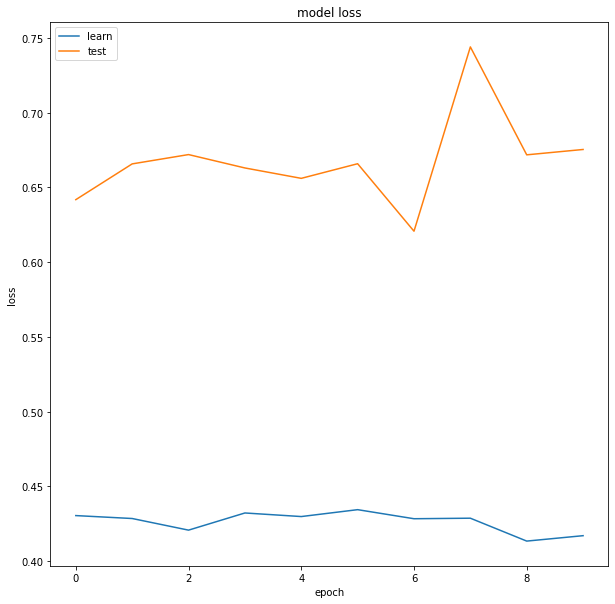

In [7]:
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["learn", "test"], loc="upper left")
plt.show()



In [8]:
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print("Accurracy: {}".format(scores[1]))



3278/3278 [==============================] - 36s 11ms/step - loss: 0.4985 - accuracy: 0.8541
Accurracy: 0.8541021347045898


In [9]:
y_pred = (model.predict(seq_array, verbose=1, batch_size=200) > 0.5).astype("int32")
# y_pred = model.predict_classes(seq_array, verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)

print("Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels")
cm = confusion_matrix(y_true, y_pred)
print(cm)



3278/3278 [==============================] - 28s 8ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[377522  39310]
 [ 56331 182371]]


In [10]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print("precision = ", precision, "\n", "recall = ", recall)


precision =  0.822673120384697 
 recall =  0.7640111938735327
